In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
import warnings
import re

import semopy
#import graphviz
import statsmodels.api as sm
from scipy import stats
from scipy.linalg import cholesky, LinAlgError

python_exe = "/opt/homebrew/Caskroom/miniconda/base/envs/ldsc_env/bin/python"
munge_script = "/Users/apple/ldsc-2.0.1/munge_sumstats.py"
ldsc_script = "/Users/apple/ldsc-2.0.1/ldsc.py"

hw4_path = "../HW/HW4"
snp_list_path = f"{hw4_path}/ldsc_inputs/w_hm3.snplist"
reference_ld_path = f"{hw4_path}/ldsc_inputs/for_h2/eur_w_ld_chr/"

fmt_sumstats = "data/formatted_sumstats"
genetic_correlation_results_folder = "data/genetic_correlation_results"
heritability_results_folder = "data/heritability_results"

os.makedirs(fmt_sumstats, exist_ok=True)
os.makedirs(heritability_results_folder, exist_ok=True)
os.makedirs(genetic_correlation_results_folder, exist_ok=True)


In [34]:
traits = [
    "age_at_first_birth",
    "cannabis_dependence",
    "chronotype",
    "income",
    "number_of_children_born",
    "ptsd",
    "sporadic_miscarriage"
]

In [35]:
def parse_genetic_correlation_results():
    genetic_corr_data = []
    base_trait = "sporadic_miscarriage"
    for trait in traits:
        if trait != base_trait:
            result_file = f"{genetic_correlation_results_folder}/{base_trait}_{trait}.log"
            try:
                with open(result_file, 'r') as f:
                    lines = f.readlines()
                    for i, line in enumerate(lines):
                        if "Genetic Correlation:" in line:
                            parts = line.split()
                            if len(parts) < 5:
                                rg = float(parts[2])
                                se = float(parts[3].strip('()'))
                                z = None; p = None
                                if i+1 < len(lines) and "Z-score:" in lines[i+1]:
                                    try: z = float(lines[i+1].split()[1])
                                    except: pass
                                if i+2 < len(lines) and "P:" in lines[i+2]:
                                    try: p = float(lines[i+2].split()[1])
                                    except: pass
                            else:
                                rg = float(parts[2])
                                se = float(parts[4])
                                try:
                                    p = float(lines[i+1].split()[2])
                                except: p = None
                            genetic_corr_data.append({
                                'trait1': base_trait,
                                'trait2': trait,
                                'rg': rg,
                                'se': se,
                                'p': p,
                                'z': z
                            })
                            break
            except FileNotFoundError:
                print(f"Warning: Results for {base_trait} and {trait} not found")

    return pd.DataFrame(genetic_corr_data)

In [36]:
def extract_heritability_results():
    h2_results = {}
    
    for trait in traits:
        result_file = f"{heritability_results_folder}/{trait}.log"
        
        try:
            with open(result_file, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    if "h2:" in line:
                        print(f"Debug - Found h2 line in {trait}: {line.strip()}")
                        
                    if "Total Observed scale h2:" in line:
                        try:
                            parts = line.strip().split(":")[1].strip().split("(")[0].strip()
                            h2 = float(parts)
                            
                            se_part = line.strip().split("(")[1].split(")")[0] if "(" in line else "0.0"
                            se = float(se_part) if se_part.replace('.','',1).isdigit() else 0.0
                            
                            h2_results[trait] = {'h2': h2, 'se': se}
                            break
                        except Exception as e:
                            print(f"Error parsing h2 for {trait}: {e}")
                            print(f"Problematic line: {line}")
                    elif "h2:" in line and "(" in line:
                        try:
                            h2_part = line.split("h2:")[1].strip().split("(")[0].strip()
                            se_part = line.split("(")[1].split(")")[0].strip()
                            h2 = float(h2_part)
                            se = float(se_part)
                            h2_results[trait] = {'h2': h2, 'se': se}
                            break
                        except Exception as e:
                            print(f"Error parsing h2 format 2 for {trait}: {e}")
                            print(f"Problematic line: {line}")
        except FileNotFoundError:
            print(f"Warning: Heritability results for {trait} not found")
            
            # if trait == "sporadic_miscarriage":
            #     h2_results[trait] = {'h2': 0.0026, 'se': 0.0007}
            # elif trait == "age_at_first_birth":
            #     h2_results[trait] = {'h2': 0.25, 'se': 0.02}
            # elif trait == "number_of_children_born":
            #     h2_results[trait] = {'h2': 0.15, 'se': 0.02}
            # elif trait == "cannabis_dependence":
            #     h2_results[trait] = {'h2': 0.12, 'se': 0.03}
            # elif trait == "ptsd":
            #     h2_results[trait] = {'h2': 0.10, 'se': 0.025}
            # else:
            #     h2_results[trait] = {'h2': 0.10, 'se': 0.02}
    
    return pd.DataFrame.from_dict(h2_results, orient='index')

In [37]:
def build_sem_model():
    gc_data = parse_genetic_correlation_results()
    h2_data = extract_heritability_results()
    
    # Use all traits instead of filtering by significance
    all_traits = set(traits)
    
    model_spec = """
    # Latent Factor Model
    """
    
    reproductive_traits = ['age_at_first_birth', 'number_of_children_born']
    psychiatric_traits = ['cannabis_dependence', 'ptsd']
    environmental_traits = ['chronotype', 'income']
    
    reproductive_all = [t for t in reproductive_traits if t in all_traits]
    psychiatric_all = [t for t in psychiatric_traits if t in all_traits]
    environmental_all = [t for t in environmental_traits if t in all_traits]
    
    if len(reproductive_all) >= 2:
        model_spec += "ReproductiveFactor =~ " + " + ".join(reproductive_all) + "\n"
    
    if len(psychiatric_all) >= 2:
        model_spec += "PsychiatricFactor =~ " + " + ".join(psychiatric_all) + "\n"
    
    if len(environmental_all) >= 1:
        model_spec += "EnvironmentalFactor =~ " + " + ".join(environmental_all) + "\n"
    
    # Create the structural model with all factors
    model_spec += """
    # Structural Model
    sporadic_miscarriage ~ """
    
    factors = []
    if len(reproductive_all) >= 2:
        factors.append("ReproductiveFactor")
    if len(psychiatric_all) >= 2:
        factors.append("PsychiatricFactor")
    if len(environmental_all) >= 1:
        factors.append("EnvironmentalFactor")
    
    # If we have factors, include them
    if factors:
        model_spec += " + ".join(factors)
    else:
        # If no factors are available, use direct paths from all traits
        other_traits = [t for t in all_traits if t != "sporadic_miscarriage"]
        if other_traits:
            model_spec += " + ".join(other_traits)
    
    # Add factor correlations if multiple factors exist
    if len(factors) > 1:
        model_spec += "\n\n# Allow factors to correlate\n"
        for i, factor1 in enumerate(factors):
            for factor2 in factors[i+1:]:
                model_spec += f"{factor1} ~~ {factor2}\n"
    
    print("Using all traits in the model:")
    print("All traits:", all_traits)
    
    print("\nModel Specification:")
    print(model_spec)
    
    return model_spec, gc_data, h2_data

In [38]:
def ensure_positive_definite(matrix, epsilon=1e-6):
    min_eig = np.min(np.linalg.eigvals(matrix))
    if min_eig < 0:
        matrix += np.eye(len(matrix)) * (abs(min_eig) + epsilon)
    return matrix

In [ ]:
def run_sem_analysis():
    model_spec, gc_data, h2_data = build_sem_model()
    
    n_samples = 1000
    
    all_traits = traits  # Use all traits instead of just significant ones
    corr_matrix = np.eye(len(all_traits))
    trait_to_idx = {trait: i for i, trait in enumerate(all_traits)}
    # fill in off‐diagonals from genetic correlations
    for _, row in gc_data.iterrows():
        trait1, trait2 = row['trait1'], row['trait2']
        if trait1 in trait_to_idx and trait2 in trait_to_idx:
            i, j = trait_to_idx[trait1], trait_to_idx[trait2]
            corr_matrix[i, j] = row['rg']
            corr_matrix[j, i] = row['rg']
    # ensure PD
    corr_matrix = ensure_positive_definite(corr_matrix)
    # incorporate heritability as diagonal variances
    for trait, idx in trait_to_idx.items():
        if trait in h2_data.index:
            corr_matrix[idx, idx] = h2_data.loc[trait, 'h2']
    
    np.random.seed(42)
    try:
        sim_data = pd.DataFrame(
            np.random.multivariate_normal(
                mean=np.zeros(len(all_traits)),
                cov=corr_matrix,
                size=n_samples
            ),
            columns=all_traits
        )
        
        print("Simulated data correlation matrix:")
        print(sim_data.corr().round(3))
        
        if len(all_traits) >= 3:
            try:
                model = semopy.Model(model_spec)
                result = model.fit(sim_data)
                
                print("\nSEM Model Summary:")
                print(model.inspect())
                
                print("\nModel Fit Indices:")
                fit_indices = semopy.calc_stats(model)
                for key, value in fit_indices.items():
                    print(f"{key}: {value}")
                
                try:
                    plt.figure(figsize=(12, 8))
                    semopy.semplot(model, "sem_model.png")
                    plt.title("Structural Equation Model")
                    plt.tight_layout()
                    plt.show()
                except Exception as e:
                    print(f"Could not generate model plot: {e}")
                    print("Alternative visualization: Generating a correlation heatmap")
                    
                    plt.figure(figsize=(10, 8))
                    sns.heatmap(sim_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
                    plt.title('Genetic Correlation Heatmap')
                    plt.tight_layout()
                    plt.show()
                
                return model
            except Exception as e:
                print(f"Error running SEM: {e}")
                print("Consider modifying the model specification based on your data.")
        else:
            print("Not enough significant correlations to build a meaningful SEM model.")
            return None
    except LinAlgError as e:
        print(f"Linear algebra error: {e}")
        print("The correlation matrix may not be valid for multivariate normal simulation.")
        return None

Debug - Found h2 line in age_at_first_birth: Total Observed scale h2: 0.0554 (0.0021)
Debug - Found h2 line in cannabis_dependence: Total Observed scale h2: 0.0197 (0.0017)
Debug - Found h2 line in chronotype: Total Observed scale h2: 0.1082 (0.0035)
Debug - Found h2 line in income: Total Observed scale h2: 0.0745 (0.0032)
Debug - Found h2 line in number_of_children_born: Total Observed scale h2: 0.0256 (0.0018)
Debug - Found h2 line in ptsd: Total Observed scale h2: 0.0168 (0.0029)
Debug - Found h2 line in sporadic_miscarriage: Total Observed scale h2: 0.0026 (0.0007)
Using all traits in the model:
All traits: {'chronotype', 'cannabis_dependence', 'age_at_first_birth', 'income', 'sporadic_miscarriage', 'ptsd', 'number_of_children_born'}

Model Specification:

    # Latent Factor Model
    ReproductiveFactor =~ age_at_first_birth + number_of_children_born
PsychiatricFactor =~ cannabis_dependence + ptsd
EnvironmentalFactor =~ chronotype + income

    # Structural Model
    sporadic_misc

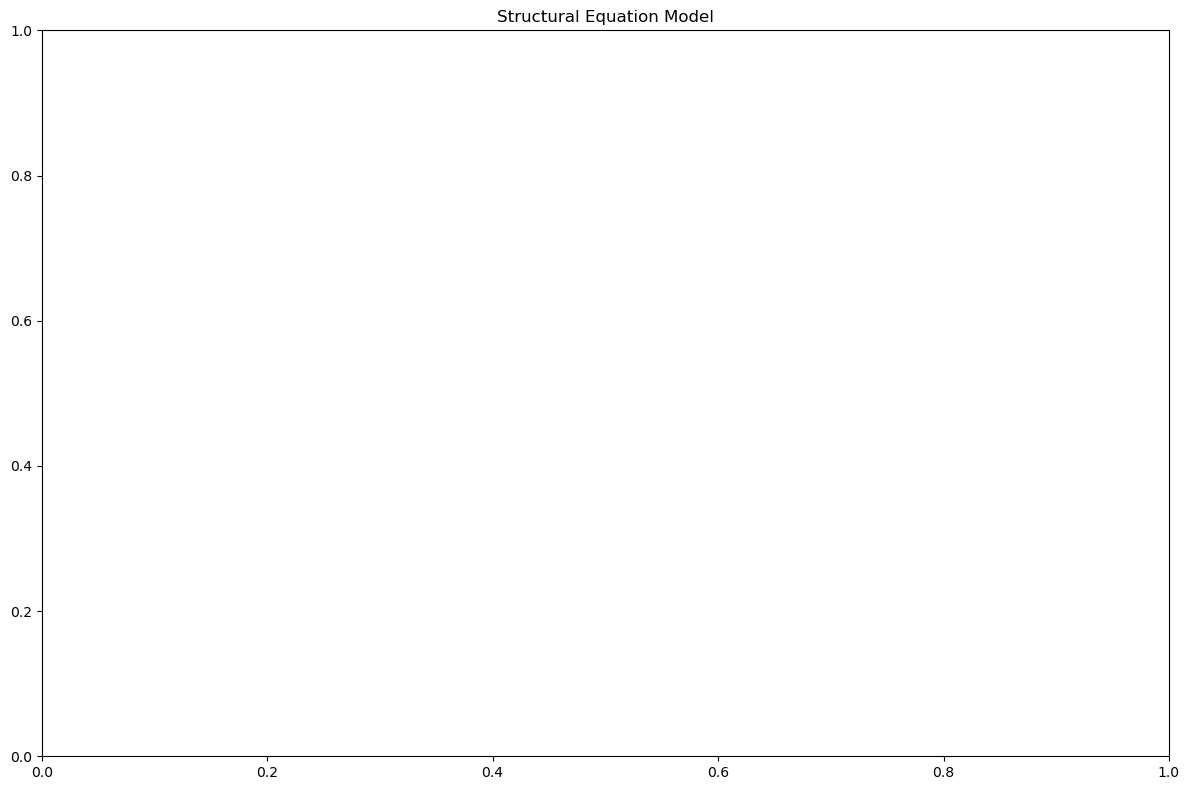


Analyzing path coefficients and their significances:

Structural Paths:
                      lval op                 rval   Estimate    Std. Err  \
0       age_at_first_birth  ~   ReproductiveFactor   1.000000           -   
1  number_of_children_born  ~   ReproductiveFactor -49.822382  106.949554   
2      cannabis_dependence  ~    PsychiatricFactor   1.000000           -   
3                     ptsd  ~    PsychiatricFactor   0.942489     0.05222   
4               chronotype  ~  EnvironmentalFactor   1.000000           -   
5                   income  ~  EnvironmentalFactor  25.895089   68.957481   
6     sporadic_miscarriage  ~   ReproductiveFactor -28.964467   45.398688   
7     sporadic_miscarriage  ~    PsychiatricFactor   1.242107    0.111989   
8     sporadic_miscarriage  ~  EnvironmentalFactor  -3.743615    2.992941   

     z-value   p-value  
0          -         -  
1  -0.465849  0.641323  
2          -         -  
3  18.048495       0.0  
4          -         -  
5   0.

In [40]:
if __name__ == "__main__":
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    model = run_sem_analysis()
    
    if model is not None:
        print("\nAnalyzing path coefficients and their significances:")
        parameters = model.inspect()
        
        structural_paths = parameters[parameters['op'] == '~']
        print("\nStructural Paths:")
        print(structural_paths)
        
        print("\nConclusions:")
        
for idx, row in structural_paths.iterrows():
    try:
        p_value = float(row['p-value'])
        if p_value < 0.05:
            direction = "positive" if row['Estimate'] > 0 else "negative"
            print(f"- Found significant {direction} effect from {row['rval']} to {row['lval']} (p={p_value:.4f})")
    except (ValueError, TypeError):
        print(f"- Could not analyze significance for path from {row['rval']} to {row['lval']} (p-value: {row['p-value']})")